In [1]:
!nvidia-smi

Fri Apr  4 19:14:49 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   69C    P8             12W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Install YOLOv8

In [3]:
!pip install ultralytics==8.3.19

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics 8.3.19 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 41.0/112.6 GB disk)


## Install Roboflow Supervision

In [4]:
!pip install supervision[assets]==0.24.0

from IPython import display
display.clear_output()

import supervision as sv
print("supervision.__version__:", sv.__version__)

supervision.__version__: 0.24.0


## example video

In [6]:


SOURCE_VIDEO_PATH = "/content/sample video.webm"

## Load pre-trained YOLOv8 model

In [7]:
!unzip weights.zip

Archive:  weights.zip
   creating: content/runs/detect/train/weights/
  inflating: content/runs/detect/train/weights/best.pt  
  inflating: content/runs/detect/train/weights/last.pt  


In [8]:
from ultralytics import YOLO

model = YOLO("content/runs/detect/train/weights/best.pt ")

## Predict and annotate single frame

In [9]:
# dict maping class_id to class_name
CLASS_NAMES_DICT = model.model.names

# the class names we have chosen
SELECTED_CLASS_NAMES = ['car', 'motorcycle', 'bus', 'truck']

# class ids matching the class names we have chosen
SELECTED_CLASS_IDS = [
    {value: key for key, value in CLASS_NAMES_DICT.items()}[class_name]
    for class_name
    in SELECTED_CLASS_NAMES
]

In [10]:
import supervision as sv
import numpy as np

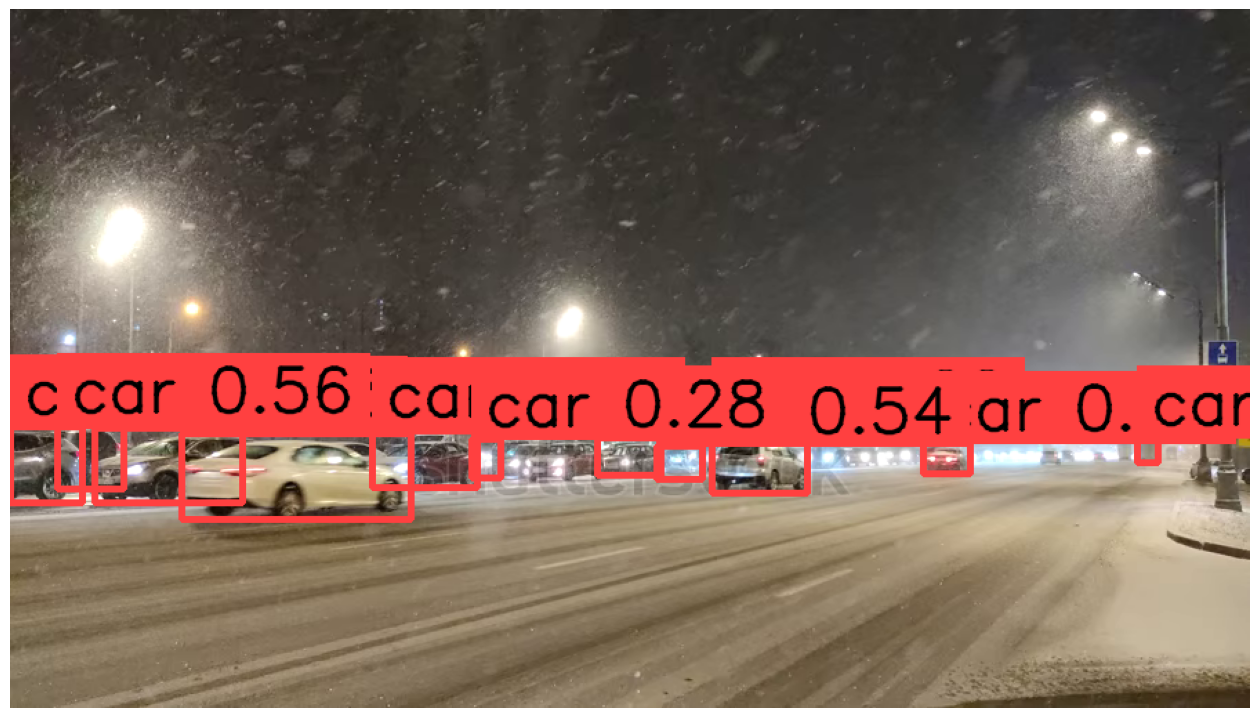

In [11]:
# create frame generator
generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
# create instance of BoxAnnotator and LabelAnnotator
box_annotator = sv.BoxAnnotator(thickness=4)
label_annotator = sv.LabelAnnotator(text_thickness=2, text_scale=1.5, text_color=sv.Color.BLACK)
# acquire first video frame
iterator = iter(generator)
frame = next(iterator)
# model prediction on single frame and conversion to supervision Detections
results = model(frame, verbose=False)[0]

# convert to Detections
detections = sv.Detections.from_ultralytics(results)
# only consider class id from selected_classes define above
detections = detections[np.isin(detections.class_id, SELECTED_CLASS_IDS)]

# format custom labels
labels = [
    f"{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
    for confidence, class_id in zip(detections.confidence, detections.class_id)
]

# annotate and display frame
annotated_frame = frame.copy()
annotated_frame = box_annotator.annotate(
    scene=annotated_frame, detections=detections)
annotated_frame = label_annotator.annotate(
    scene=annotated_frame, detections=detections, labels=labels)

%matplotlib inline
sv.plot_image(annotated_frame, (16, 16))

## Predict and annotate whole video

In [12]:
# settings
LINE_START = sv.Point(0 + 50, 1500)
LINE_END = sv.Point(3840 - 50, 1500)

TARGET_VIDEO_PATH = f"{HOME}/result.mp4"

In [13]:
sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

VideoInfo(width=898, height=506, fps=29, total_frames=493)

In [14]:
# create BYTETracker instance
byte_tracker = sv.ByteTrack(
    track_activation_threshold=0.25,
    lost_track_buffer=30,
    minimum_matching_threshold=0.8,
    frame_rate=30,
    minimum_consecutive_frames=3)

byte_tracker.reset()

# create VideoInfo instance
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

# create frame generator
generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

# create LineZone instance, it is previously called LineCounter class
line_zone = sv.LineZone(start=LINE_START, end=LINE_END)

# create instance of BoxAnnotator, LabelAnnotator, and TraceAnnotator
box_annotator = sv.BoxAnnotator(thickness=4)
label_annotator = sv.LabelAnnotator(text_thickness=2, text_scale=1.5, text_color=sv.Color.BLACK)
trace_annotator = sv.TraceAnnotator(thickness=4, trace_length=50)

# create LineZoneAnnotator instance, it is previously called LineCounterAnnotator class
line_zone_annotator = sv.LineZoneAnnotator(thickness=4, text_thickness=4, text_scale=2)

# define call back function to be used in video processing
def callback(frame: np.ndarray, index: int) -> np.ndarray:
    # model prediction on single frame and conversion to supervision Detections
    results = model(frame, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)
    # only consider class id from selected_classes define above
    detections = detections[np.isin(detections.class_id, SELECTED_CLASS_IDS)]
    # tracking detections
    detections = byte_tracker.update_with_detections(detections)
    labels = [
        f"#{tracker_id} {model.model.names[class_id]} {confidence:0.2f}"
        for confidence, class_id, tracker_id
        in zip(detections.confidence, detections.class_id, detections.tracker_id)
    ]
    annotated_frame = frame.copy()
    annotated_frame = trace_annotator.annotate(
        scene=annotated_frame, detections=detections)
    annotated_frame = box_annotator.annotate(
        scene=annotated_frame, detections=detections)
    annotated_frame = label_annotator.annotate(
        scene=annotated_frame, detections=detections, labels=labels)

    # update line counter
    line_zone.trigger(detections)
    # return frame with box and line annotated result
    return line_zone_annotator.annotate(annotated_frame, line_counter=line_zone)

# process the whole video
sv.process_video(
    source_path = SOURCE_VIDEO_PATH,
    target_path = TARGET_VIDEO_PATH,
    callback=callback
)